In [1]:
import sys
sys.path.append("..")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.config import DATA_PATH, input_keys, agg_trns
from src.preprocess import Preprocessor
from sklearn.ensemble import IsolationForest

%load_ext autoreload
%autoreload 2

In [2]:
df = pd.read_csv(DATA_PATH / 'generated_ad_data.csv.gz', sep=';', compression='gzip', parse_dates=[input_keys.TIME_KEY])
df.head()

,REQUEST_TIME,DEVICE_IP,DEVICE_IFA,GEO_CURRENT_CITY,DEVICE_LANGUAGE,GENERATED_AS_BOT
0,2022-12-24 09:47:37.031602,9.247.181.78,b969fffa-bfa3-4073-a438-e8dc99868886,Holon,he,0
1,2022-12-24 10:31:30.499043,9.247.181.78,b969fffa-bfa3-4073-a438-e8dc99868886,Holon,he,0
2,2022-12-24 10:32:40.306333,9.247.181.78,b969fffa-bfa3-4073-a438-e8dc99868886,Holon,he,0
3,2022-12-24 10:04:02.963917,9.247.181.78,b969fffa-bfa3-4073-a438-e8dc99868886,Holon,he,0
4,2022-12-24 11:42:46.137821,9.247.181.78,b969fffa-bfa3-4073-a438-e8dc99868886,Holon,he,0


In [3]:
preprocessor = Preprocessor(input_keys, agg_trns)
final_df = preprocessor.fit_transform(df)

final_df['BOT'] = df.groupby(input_keys.PRIMARY_KEY)['GENERATED_AS_BOT'].agg(min).values

D:\Data\Data Science\Interviews\Intelos\sleep-detector\sleep-detector\jnb\..\src\preprocess.py:81: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_feats.drop(columns=self.input_keys.PRIMARY_KEY)


After feature engineering:

In [4]:
final_df.head()

,DEVICE_IFA,0,1,2,3,4,5,6,7,8,...,CUMNORM_21,CUMNORM_22,"(TIME_DIFF, mean)","(TIME_DIFF, max)","(TIME_DIFF, min)","(TIME_DIFF, std)","(DEVICE_IP, nunique)","(GEO_CURRENT_CITY, nunique)","(DEVICE_LANGUAGE, nunique)",BOT
0,002fcc48-c604-4340-93b7-27401bff7467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,...,0.681818,0.772727,1376.595464,5386.227574,1.758875,1351.336296,1,1,1,0
1,004b058d-189d-4f8e-9864-9a6ca3723ce6,14.0,2.0,9.0,8.0,9.0,9.0,10.0,8.0,7.0,...,0.933333,0.957576,516.351955,3903.840942,3.553801,576.832394,4,1,1,1
2,005161f5-fb3d-456e-99d9-a3d262628fd3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.979167,1.000000,1613.466506,37797.919039,16.648525,5514.821047,3,1,1,0
3,0064b514-2e02-4edf-9f6d-aec6928f326d,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.433333,0.466667,2872.256027,43267.259213,3.121894,7951.719210,2,1,1,0
4,006b5ad9-6725-44d8-8208-a0913cc68699,0.0,0.0,0.0,0.0,0.0,0.0,6.0,3.0,1.0,...,0.918919,1.000000,1676.111476,14581.612805,38.812137,2591.837275,2,1,1,0


# Visualizations

The average hourly activity profiles are different for bots and humans:

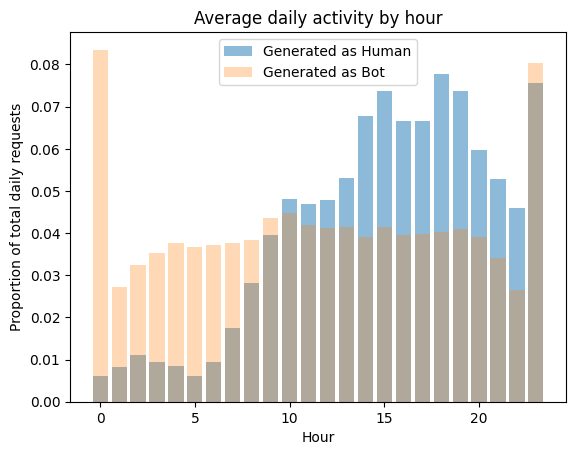

In [5]:
norm_df = final_df[[f'NORM_{i}' for i in range(24)]]

plt.title('Average daily activity by hour')
plt.bar(range(24), norm_df[final_df['BOT']==0].mean(axis=0), alpha=0.5, label='Generated as Human')
plt.bar(range(24), norm_df[final_df['BOT']==1].mean(axis=0), alpha=0.3, label='Generated as Bot')
plt.ylabel('Proportion of total daily requests')
plt.xlabel('Hour')
plt.legend()
plt.show()

Bots:
- have much less number of hours with zero activity;
- can have large total number of requests daily;
- have less average time difference between consecutive requests;
- have less variance (std) in the time difference between consecutive requests.

Illustrations:

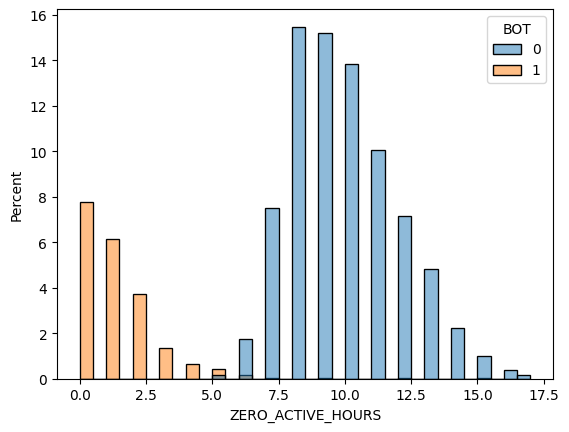

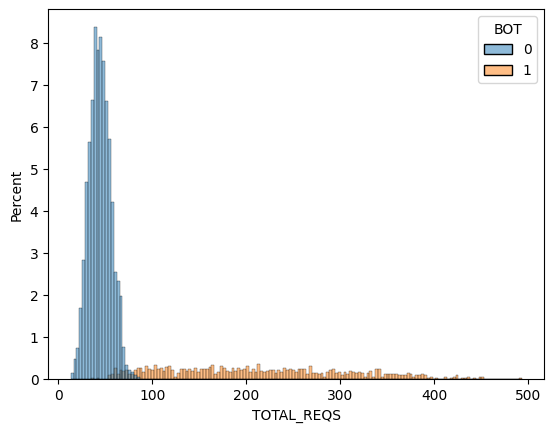

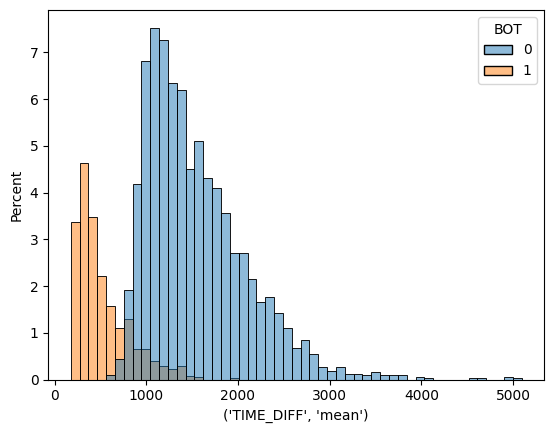

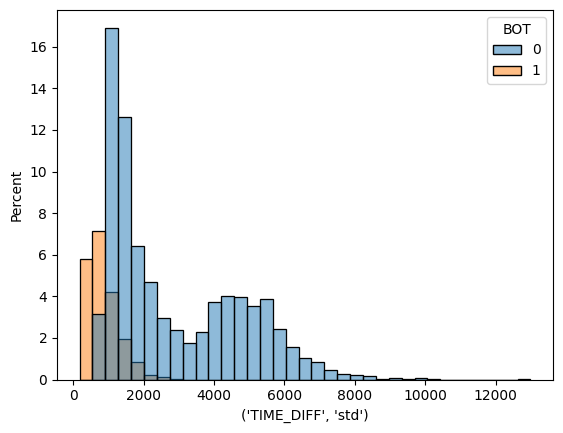

In [6]:
features = ['ZERO_ACTIVE_HOURS', 'TOTAL_REQS', ('TIME_DIFF', 'mean'), ('TIME_DIFF', 'std')]
for col in features:
    sns.histplot(x=final_df[col], hue=final_df['BOT'], stat='percent')
    plt.show()

Graphs provided above show that features produced can indeed be used to identify abnormal sleeping activity.

# Modelling

In [7]:
forest = IsolationForest(n_estimators=200, contamination=.2, max_features=1)
train_preds = forest.fit_predict(final_df.drop(columns=input_keys.PRIMARY_KEY))

C:\Users\Vlad\Miniconda3\envs\sleepdetect\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Vlad\Miniconda3\envs\sleepdetect\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


In [8]:
print('Overall accuracy on train part:', ((train_preds < 0) == final_df['BOT']).mean())
print('Recall on train part:', (train_preds[final_df['BOT'] == 1] < 0).mean())
print('Precision on train part:', final_df[train_preds < 0]['BOT'].mean())

Overall accuracy on train part: 0.9632600258732212
Recall on train part: 0.9019108280254777
Precision on train part: 0.9159120310478654


# Checking on test data (generated by the same process):

In [9]:
test_df = pd.read_csv(
    DATA_PATH / 'generated_ad_data_test.csv.gz', sep=';', compression='gzip', parse_dates=[input_keys.TIME_KEY]
)
test_df.head()

,REQUEST_TIME,DEVICE_IP,DEVICE_IFA,GEO_CURRENT_CITY,DEVICE_LANGUAGE,GENERATED_AS_BOT
0,2022-12-21 00:08:13.892044,60.137.181.243,0c07d6b9-da4a-4039-8642-2bcb7d393da8,Rehovot,he,0
1,2022-12-21 08:13:26.462536,130.93.208.144,0c07d6b9-da4a-4039-8642-2bcb7d393da8,Rehovot,he,0
2,2022-12-21 08:47:09.527610,60.137.181.243,0c07d6b9-da4a-4039-8642-2bcb7d393da8,Rehovot,he,0
3,2022-12-21 08:42:55.280506,130.93.208.144,0c07d6b9-da4a-4039-8642-2bcb7d393da8,Rehovot,he,0
4,2022-12-21 08:42:33.389925,60.137.181.243,0c07d6b9-da4a-4039-8642-2bcb7d393da8,Rehovot,he,0


In [10]:
final_test_df = preprocessor.transform(test_df)
final_test_df['BOT'] = test_df.groupby(input_keys.PRIMARY_KEY)['GENERATED_AS_BOT'].agg(min).values

D:\Data\Data Science\Interviews\Intelos\sleep-detector\sleep-detector\jnb\..\src\preprocess.py:81: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_feats.drop(columns=self.input_keys.PRIMARY_KEY)


In [11]:
test_preds = forest.predict(final_test_df.drop(columns=input_keys.PRIMARY_KEY))

C:\Users\Vlad\Miniconda3\envs\sleepdetect\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


In [12]:
print('Overall accuracy on test part:', ((test_preds < 0) == final_test_df['BOT']).mean())
print('Recall on test part:', (test_preds[final_test_df['BOT'] == 1] < 0).mean())
print('Precision on test part:', final_test_df[test_preds < 0]['BOT'].mean())

Overall accuracy on test part: 0.9516407599309153
Recall on test part: 0.9099099099099099
Precision on test part: 0.8487394957983193


# Visualize test performance

In [13]:
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, KMeans

In [14]:
tsne = TSNE(n_components=2, perplexity=35)
data_2d = tsne.fit_transform(final_test_df.drop(columns=[input_keys.PRIMARY_KEY]))

C:\Users\Vlad\Miniconda3\envs\sleepdetect\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Vlad\Miniconda3\envs\sleepdetect\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Vlad\Miniconda3\envs\sleepdetect\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


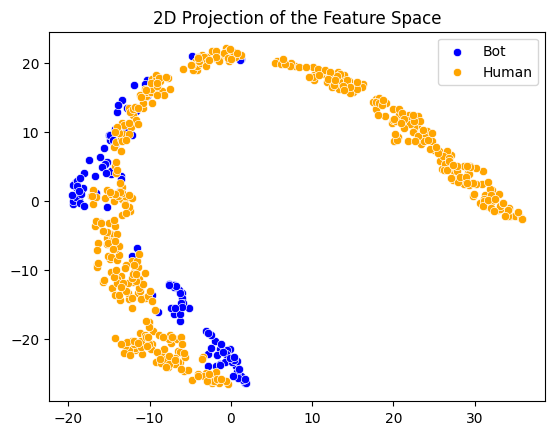

In [15]:
plt.title('2D Projection of the Feature Space')
sns.scatterplot(
    x=data_2d[final_test_df['BOT'] == 1][:, 0], y=data_2d[final_test_df['BOT'] == 1][:, 1], color='blue', label='Bot'
)
sns.scatterplot(
    x=data_2d[final_test_df['BOT'] == 0][:, 0], y=data_2d[final_test_df['BOT'] == 0][:, 1], color='orange', label='Human'
)
plt.legend()
plt.show()

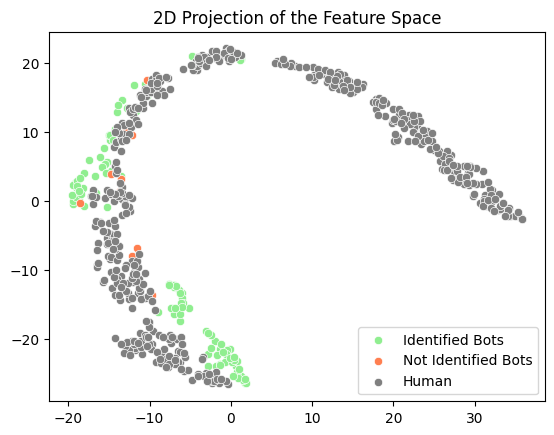

In [16]:
plt.title('2D Projection of the Feature Space')
sns.scatterplot(
    x=data_2d[(final_test_df['BOT'] == 1) & (test_preds < 0)][:, 0], y=data_2d[(final_test_df['BOT'] == 1) & (test_preds < 0)][:, 1], 
    color='lightgreen', label='Identified Bots')
sns.scatterplot(
    x=data_2d[(final_test_df['BOT'] == 1) & (test_preds >= 0)][:, 0], y=data_2d[(final_test_df['BOT'] == 1) & (test_preds >= 0)][:, 1], 
    color='coral', label='Not Identified Bots')
sns.scatterplot(
    x=data_2d[final_test_df['BOT'] == 0][:, 0], y=data_2d[final_test_df['BOT'] == 0][:, 1], color='grey', label='Human'
)

plt.legend()
plt.show()